# CPSC 330 Lecture 9

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Evaluation metrics True/False (10 min)
- Introducing some other classifiers (20 min)
- Break (5 mins)
- Ensembles: averaging (20 min)
- Ensembles: stacking (20 min)
- Summary

Piazza:

- Ensembles True/False questions

## Learning objectives

- Name a few popular tree-based classifier.
- Name a few key hyperparameters of random forest classifiers.
- Weigh the pros and cons of using a classifier from outside scikit-learn.
- Employ ensemble classifier approaches, in particular model averaging and stacking
- Compare averaging vs. stacking
- Interpret the coefficients of the meta-classifier in the case of stacking

## Announcements

- hw schedule for the rest of the course posted at https://github.com/UBC-CS/cpsc330#homework-schedule
- hw4 posted, due Monday 11:59pm
- Evaluation metrics true/false: https://piazza.com/class/kb2e6nwu3uj23?cid=283
- Midterm format: https://piazza.com/class/kb2e6nwu3uj23?cid=281 and https://piazza.com/class/kb2e6nwu3uj23?cid=284

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
from IPython.display import display

In [123]:
# copied from lecture 2
import re
import graphviz
from sklearn.tree import export_graphviz

def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_.astype(str), impurity=False, precision=4)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## Introducing some other classifiers (20 min)


In [5]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')

In [6]:
df_train, df_test = train_test_split(cc_df, random_state=123)

Today I will use a smaller data set for speed of the demos:

In [7]:
df_train = df_train.sample(frac=0.1)

In [8]:
df_train.shape

(21360, 31)

In [9]:
X_train = df_train.drop(columns=['Class'])
y_train = df_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [10]:
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
]) 

In [11]:
score_method = 'average_precision'

In [12]:
lr_results = pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
lr_results

fit_time       0.215157
score_time     0.006149
test_score     0.746118
train_score    0.820779
dtype: float64

In [13]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=123) # scaling not needed

In [14]:
dt_results = pd.DataFrame(cross_validate(dt, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
dt_results

fit_time       0.189141
score_time     0.003725
test_score     0.518204
train_score    1.000000
dtype: float64

How about some other classifiers?

In [15]:
from sklearn.ensemble import RandomForestClassifier

- This is basically the average of a bunch of random decision trees. 
- We'll talk about averaging later today!

In [16]:
rf = RandomForestClassifier(class_weight='balanced', random_state=999) # scaling not needed

In [17]:
rf_results = pd.DataFrame(cross_validate(rf, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
rf_results

fit_time       2.274872
score_time     0.027058
test_score     0.788906
train_score    1.000000
dtype: float64

This gets a better score!

In [18]:
summary = pd.DataFrame([lr_results, dt_results, rf_results], index=["logistic regression", "decision tree", "random forest"])
summary.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
random forest,2.274872,0.027058,0.788906,1.000000
logistic regression,0.215157,0.006149,0.746118,0.820779
decision tree,0.189141,0.003725,0.518204,1.000000


### Q&A

<br><br><br><br>

### What are these random forests you speak of?

- They are a collection of decision trees.
- Each tree "votes" on the prediction, majority rules (more on this later).
- Each tree (and split) is limited in the number of features it can look at.
- Each tree is training on a slightly different version of the dataset. 

We can actually look at the sub-trees in a trained random forest:



Tree 1


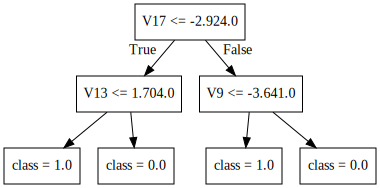



Tree 2


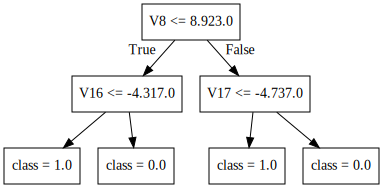



Tree 3


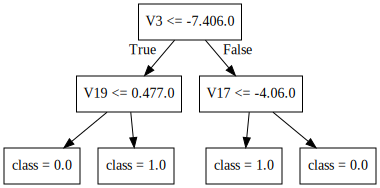

In [19]:
rf_demo = RandomForestClassifier(max_depth=2, n_estimators=3, random_state=321)
rf_demo.fit(X_train, y_train)
for i, tree in enumerate(rf_demo.estimators_):
    print("\n\nTree", i+1)
    display(display_tree(X_train.columns, tree))

Note that they look at different features. 

Some notable hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)

In [20]:
# ??RandomForestClassifier

### Q&A

(Pause for Q&A)

<br><br><br><br>

- We can also try some other tree-based classifiers using "gradient boosting".
  - We won't go into the details of how they work, but we can think of them as more complicated random forests.
- Important to note that all of these **do** implement `predict_proba` so we can use something like ROC AUC.
  - The probability scores come from the variation in the votes across trees, and other fancier sources.
- But not all of them implement `class_weight`.

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
gb = GradientBoostingClassifier(random_state=999) # no class_weight

In [23]:
gb_results = pd.DataFrame(cross_validate(gb, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
gb_results

fit_time       14.985047
score_time      0.006453
test_score      0.638259
train_score     0.866346
dtype: float64

In [24]:
summary = pd.DataFrame([lr_results, dt_results, rf_results, gb_results], index=["logistic regression", "decision tree", "random forest", "gradient boosting"])
summary.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
random forest,2.274872,0.027058,0.788906,1.000000
logistic regression,0.215157,0.006149,0.746118,0.820779
gradient boosting,14.985047,0.006453,0.638259,0.866346
decision tree,0.189141,0.003725,0.518204,1.000000


- Not very good, possible because of `class_weight`. (Though `class_weight` should not matter so much for this scoring metric - to be investigated further...)
- It's also _very_ slow, so we'll drop it going forward.

#### Classifiers outside sklearn

- We can also try some other gradient boosting tree-based classifiers from outside sklearn.
- There are more "fancy" are are **extremely popular**.  
- Over time, people created "sklearn-friendly" wrappers so that these classifiers are compatible with all that we know & love.
  - As long as they implement `fit` and `predict` and `predict_proba` and `score` we can plug them right in.

In [25]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

`XGBClassifier` doesn't have an easy implementation of `class_weight='balanced'` AFAIK.

In [26]:
vc = y_train.value_counts()
vc = vc/vc.iloc[1]
vc

0    453.468085
1      1.000000
Name: Class, dtype: float64

In [31]:
classifiers = {
    'logistic regression' : pipe_lr,
    'decision tree' : dt,
    'random forest' : rf,
    'XGBoost' : XGBClassifier(scale_pos_weight=500, random_state=999), 
    'LightGBM' : LGBMClassifier(class_weight='balanced', random_state=999),
    'CatBoost' : CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=999)
}

In [56]:
mean_results_dict = dict()
std_results_dict = dict()
for name, classifier in classifiers.items():
    print(name)
    result = pd.DataFrame(cross_validate(classifier, X_train, y_train, scoring=score_method, return_train_score=True))
    mean_results_dict[name] = result.mean()
    std_results_dict[name] = result.std()

logistic regression
decision tree
random forest
XGBoost
LightGBM
CatBoost


In [57]:
results = pd.DataFrame(mean_results_dict).T
std_results  = pd.DataFrame(std_results_dict).T

In [60]:
results = results.assign(test_score_std=std_results["test_score"])

In [61]:
results.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score,test_score_std
XGBoost,0.926108,0.008277,0.835194,1.000000,0.092386
CatBoost,9.252291,0.006278,0.789193,0.999145,0.071582
random forest,2.289599,0.027257,0.788906,1.000000,0.087181
LightGBM,0.491935,0.014840,0.788775,1.000000,0.074766
logistic regression,0.237156,0.005316,0.746118,0.820779,0.153621
decision tree,0.183530,0.003058,0.518204,1.000000,0.085817


My thoughts:

- Keep in mind all of the above is with:
  - Default hyperparameters (except `class_weight`)
  - A particular scoring metric
- Look at the std for test score (across 5 folds) - it's very high!
  - So we can't exactly trust the ordering above, or even the scores that much.
  - Stratified splits might help here? To investigate.
- All the trees totally overfit
  - We may do better by tweaking the hyperparameters
- Look at the fit times! And the score times are also interesting.
  - Is is typical that `predict`/`score` are much faster than `fit` (with one notable exception, coming later in the course)
- Note that CatBoost took about 10x longer than XGBoost and the scores only differ by <1%
  - We took the mean of the sub-scores, but we might want to look more closely.

#### What classifier should I use?!

- Cop out answer: whichever gets the highest CV score.
  - But we shouldn't overuse the validation set.
  - This seems more reasonable when you have more data.
  - It's time-consuming.
- You may also have a reason to choose one over another.
- One reason is _interpretability_, which we'll talk a bit more about next week.
  - This is an area of growing interest and concern in ML.
- Other considerations could be speed (fit and/or predict), maintainability of the code.
- Finally, you could use all of them! (That's what the rest of today is about!)

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Break (5 min)

<br><br>

## Ensembles: averaging (20 min)

Earlier we looked at a bunch of classifiers:

In [62]:
classifiers

{'logistic regression': Pipeline(steps=[('scale', StandardScaler()),
                 ('lr',
                  LogisticRegression(class_weight='balanced', max_iter=1000))]),
 'decision tree': DecisionTreeClassifier(class_weight='balanced', random_state=123),
 'random forest': RandomForestClassifier(class_weight='balanced', random_state=999),
 'XGBoost': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=999, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=500, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'Lig

In [63]:
averaging_model = VotingClassifier(list(classifiers.items()), voting='soft') # need the list() here for cross_val to work!

- This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifiers.
  - Or, more generally, classifier pipelines!
- Note the `voting='soft'`
  - By default (`voting='hard'`) it uses the output of `predict` and actually votes.
  - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.
  - The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [64]:
averaging_model.fit(X_train, y_train);

Note: it seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

Let's look at a particular test case that is actually a fraud case (y=1):

In [81]:
t = np.where(y_test)[0][1]

In [82]:
averaging_model.predict(X_test.iloc[t:t+1])

array([1])

For hard voting, these are the votes:

In [83]:
r1 = {name : classifier.predict(X_test[t:t+1])[0] for name, classifier in averaging_model.named_estimators_.items()}
r1

{'logistic regression': 1,
 'decision tree': 0,
 'random forest': 1,
 'XGBoost': 1,
 'LightGBM': 1,
 'CatBoost': 1}

For soft voting, these are the scores:

In [85]:
r2 = {name : classifier.predict_proba(X_test[t:t+1])[0] for name, classifier in averaging_model.named_estimators_.items()}
pd.DataFrame(r2).T

,0,1
logistic regression,0.000000,1.000000
decision tree,1.000000,0.000000
random forest,0.400000,0.600000
XGBoost,0.000133,0.999867
LightGBM,0.000046,0.999954
CatBoost,0.001123,0.998877


In [86]:
pd.DataFrame(r2).T.mean()

0    0.23355
1    0.76645
dtype: float64

In [87]:
averaging_model.predict_proba(X_test.iloc[t:t+1])

array([[0.23355042, 0.76644958]])

(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

Let's see how well this model performs.

In [90]:
vot_res = pd.DataFrame(cross_validate(averaging_model, X_train, y_train, scoring=score_method, return_train_score=True))

In [98]:
vot_res_mean = vot_res.mean()
vot_res_std = vot_res.std()

In [104]:
vot_res_df = pd.DataFrame(vot_res_mean, columns=["Voting"]).T
vot_res_df = vot_res_df.assign(test_score_std=[vot_res_std["test_score"]])

In [105]:
results_with_avg = pd.concat((results, vot_res_df))
results_with_avg.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score,test_score_std
XGBoost,0.926108,0.008277,0.835194,1.000000,0.092386
CatBoost,9.252291,0.006278,0.789193,0.999145,0.071582
random forest,2.289599,0.027257,0.788906,1.000000,0.087181
LightGBM,0.491935,0.014840,0.788775,1.000000,0.074766
Voting,10.028424,0.065686,0.786425,1.000000,0.093385
logistic regression,0.237156,0.005316,0.746118,0.820779,0.153621
decision tree,0.183530,0.003058,0.518204,1.000000,0.085817


It appears that we did a bit better than even our best classifier!

TODO: jk, this was true in a previous random seed but not now

- Question: how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??
  
<br><br><br>

Here's how this can work:

| Example | log reg    | rand for     | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


### Q&A

<br><br><br><br>

In short, as long as the different models make different mistakes, this can work.

This is amazing, why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

Back to ensembling: when can I do this?

- You can comebine completely different estimators, or similar estimators.
  - (In fact, a random forest itself is an ensemble of decision trees.)
- But you can also try different hyperparameter values.
  - So... the hyperparameters of the ensemble now go even deeper.
  - The inception never ends... 

### Q&A

(Pause for Q&A)

<br><br><br><br>

## Ensembles: stacking (20 min)

- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use their outputs as _inputs to another model_.
- By default for classification, it uses logistic regression.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [106]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; I'm going to remove CatBoost

In [107]:
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [108]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

In [109]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)

In [110]:
stacking_model.predict(X_test[t:t+1])

array([1])

In [111]:
stacking_model.predict_proba(X_test[t:t+1])

array([[0.28045983, 0.71954017]])

(This is the `predict_proba` from logistic regression)

Let's see how well this model performs.

In [112]:
pd.DataFrame(cross_validate(stacking_model, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

fit_time       16.328395
score_time      0.053243
test_score      0.783362
train_score     1.000000
dtype: float64

- The situation here is a bit mind-boggling.
- AFAIK on each fold of cross-validation it is doing cross-validation.
- And then in there you might have pipelines and...
- This is really loops within loops within loops within loops...

## Q&A

(Pause for Q&A)

<br><br><br><br>

Here is the input features (X) to the meta-model:

In [113]:
r3 = {name : classifier.predict_proba(X_test[t:t+1])[0] for name, classifier in stacking_model.named_estimators_.items()}
r3 = pd.DataFrame(r3).T
r3

,0,1
logistic regression,0.000000,1.000000
decision tree,1.000000,0.000000
random forest,0.400000,0.600000
XGBoost,0.000133,0.999867
LightGBM,0.000046,0.999954


(Because this needs to work for multi-class now I'm not quite sure if both probabilities are going in or just one - I think just one - this is a bit simpler for regression!)

- If the meta-model is logistic regression (which it is by default), you are taking a weighted average of these outputs and learning the weights from the data.

In [114]:
stacking_model.final_estimator_.coef_

array([[2.59483414, 1.300195  , 1.74174005, 2.06847608, 2.87194886]])

In [115]:
pd.DataFrame(data=stacking_model.final_estimator_.coef_[0], index=classifiers_nocat.keys(), columns=["Coefficient"])

,Coefficient
logistic regression,2.594834
decision tree,1.300195
random forest,1.741740
XGBoost,2.068476
LightGBM,2.871949


In [116]:
#??StackingClassifier

- It seems that the XGBoost is being trusted the most / counting for most.
- We can also try a different final estimator:

In [117]:
stacking_model_tree = StackingClassifier(list(classifiers_nocat.items()), 
                 final_estimator=DecisionTreeClassifier(max_depth=3))

In [118]:
#pd.DataFrame(cross_validate(stacking_model_tree, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

The results are not very good. But we can look at the tree:

In [119]:
stacking_model_tree.fit(X_train, y_train);

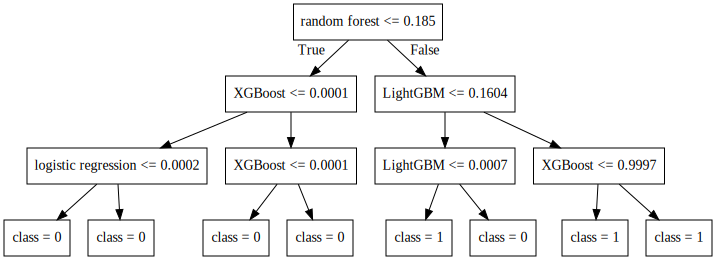

In [124]:
display_tree(list(classifiers_nocat.keys()), stacking_model_tree.final_estimator_)

This is so cool!! (Well,  think so)

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Summary 

- There's a big world of classifiers out there.
  - Tree-based classifiers are particularly popular and effective on a wide range of problems. 
  - These can be much more complex than LogisticRegression, which only learns one coefficient per feature.
- We sometimes need to leave the world of scikit-learn (and more of that later in the course!).
- Ensembles are usually pretty effective.
  - But they trade off code complexity and code speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally more accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- Remember, everything we've done is subject to earlier warnings:
  - Check for small datasets
  - Check the CV folds
  - Check the test set
  - Think carefully about which scoring metric is suitable for your problem